# Plot mcc tree with host transitions and summarize tree 

I've run a 3-deme, multitype tree model in beast. I turned off migration rates from humans (so there can be no human to bird migration events) and ran 3 chains for 100,000 steps each. Honestly, the runs did not converge very well. The model REALLY wants humans to be a source population, I think because of rapid coalescence in the poultry deme. So I think from looking at the summary tree that there are quite a few inferred wild to human events, which is weird. I think from a cursory glance that we are also underestimating the circulation within the poultry deme. However, I need to actually plot out the tree and the estimates to be sure and to think about next steps for how to maybe get a more realistic picture of host switching. 

In [1]:
import glob
import re,copy, imp
import pandas as pd 
import numpy as np

# for this to work, you will need to download the most recent version of baltic, available here 
bt = imp.load_source('baltic', '/Users/lmoncla/src/baltic/baltic/baltic.py')

%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.patheffects as path_effects
import matplotlib.lines as mlines
from matplotlib.font_manager import FontProperties
import matplotlib.colors as clr
import textwrap as textwrap
from textwrap import wrap

import rpy2
%load_ext rpy2.ipython

In [2]:
from datetime import date
current_date = str(date.today())

In [3]:
# define colors 
domestic_color="#4E83AE"
wild_color="#CEB540"
human_color="#DE4428"

In [4]:
mpl.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
mpl.rc('text', usetex='false') 
mpl.rcParams.update({'font.size': 22})

In [5]:
# tree_paths
constant_human_on = ""
constant_human_off = {"label": "constant-human-off",
    "tree":"beast-runs/2021-03-15-mascot-3deme-constant/no-human-mig/2021-03-15-mascot-3deme-constant-human-off.combined.mcc.tree"}
skyline_human_on =  ""
skyline_human_off = {"label": "skyline-human-off", 
                     "tree": "beast-runs/2021-07-26-mascot-3deme-skyline-with-mig-fixed-log/with-extra-logger/combined-trees-2021-08-23.mcc.tree"}

In [6]:
# read in tree
to_run = skyline_human_off

tree = bt.loadNexus(to_run['tree'])
label = to_run['label']

In [7]:
for k in tree.Objects: 
    if k.branchType == "node":
        #print(k.parent.traits)
        pass

### Plot a full summary tree, colored by host 

In [8]:
def plot_full_mcc_tree(width, length, tree, filename, traitName):
    
    fig,ax = plt.subplots(figsize=(width,length),facecolor='w')

    # node_colors = clr.LinearSegmentedColormap.from_list('custom ', [Not_Marshallese_color,Marshallese_color], N=256)
    color_dict = {"human":human_color, "domestic":domestic_color, "wild":wild_color, "ancestor":'grey'}

    # # this sets the vertical dashed lines on the tree; plot a dashed line every other year from 1990 to 2020
    min_date = 1990
    dates_ls = []
    for i in np.arange(min_date,2021,5):
        dates_ls.append(i) 
#     [ax.axvline(i,ls='--',lw=2,color='grey',zorder=0, alpha=0.6) for i in dates_ls]

    # set date labels to be every 4
    # date_labels = []
    # for d in dates_ls[::2]:
    #     date_labels.append(dates_dict[d]['label'])
    #     if d < 2020:
    #         date_labels.append("")

    branchWidth=1.25 ## default branch width
    tipSize = 12

    # k objects are tips, nodes, branches
    for k in tree.Objects: ## iterate over objects in tree
        x=k.absoluteTime ## or use absolute time instead
        y=k.y 

        xp=k.parent.absoluteTime ## get x position of current object's parent
        if x==None: ## matplotlib won't plot Nones, like root
            x=0.0
        if xp==None:
            xp=x

        if k.branchType=='leaf': ## if leaf...        
            c=color_dict[k.traits[traitName]]
            s=tipSize
            parent_color = color_dict[k.parent.traits[traitName]]
            a=k.parent.traits[traitName+'.prob']

            ax.scatter(x,y,s=s,facecolor=c,edgecolor='none',zorder=11) ## plot circle for every tip
            ax.scatter(x,y,s=s+0.8*s,facecolor='k',edgecolor='none',zorder=10) ## plot black circle underneath
            ax.plot([xp,x],[y,y],lw=node_branchwidth,color=parent_color,alpha=a,ls='-',zorder=9)

        elif k.branchType=='node': ## if node...
            number_children = len(k.leaves)
            node_branchwidth = branchWidth + number_children*0.0025

            # if we are not at the root
            if k.parent.traits != {}:
                c=color_dict[k.parent.traits[traitName]]
                a=k.parent.traits[traitName+'.prob']
                parent_color = color_dict[k.parent.traits[traitName]]
            else:
                print("root")
                c=color_dict[k.traits[traitName]]
                a=k.traits[traitName+'.prob']
                parent_color = c

            # this is the vertical line connecting nodes; 
            ax.plot([x,x],[k.children[-1].y,k.children[0].y],lw=node_branchwidth,color=c,alpha=a,ls='-',zorder=9)

            # this is the horizontal line connecting internal nodes to other nodes, or tips to nodes 
    #         if k.parent:
    #             if k.parent in node_types:
    #                 parent_color = colors[node_types[k.parent]["node_community_status"]]
    #             else:
    #                 print(k, k.parent)
    #                 parent_color = "red"
    #         else:
    #             parent_color = Outside_color
            ax.plot([xp,x],[y,y],lw=node_branchwidth,color=parent_color,alpha=a,ls='-',zorder=9)

        # add in a legend
        han_list = []

        # bbox to anchor puts a bounding box around where you want the legend to go, prop part is for text size
    for key in color_dict:
        if key != "ancestor":
            marker = mlines.Line2D(range(1), range(1), color = color_dict[key], marker='o', markerfacecolor = color_dict[key], label = key.replace("domestic","domestic bird").replace("wild","wild bird"), markersize = 8)
            han_list.append(marker)

    # set axis limits, remove border lines         
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    #ax.spines['bottom'].set_visible(False)

    ax.set_ylim(-5,tree.ySpan+5)
    ax.tick_params(axis='y',labelsize=0,size=0)
    ax.tick_params(axis='x',labelsize=20,size=5, width=2,color='grey')
    ax.set_xticks(dates_ls)
    ax.set_xticklabels(dates_ls)   # set date labels every 4
    #ax.set_xlim(1970,2020)
    ax.set_xlim(min_date,2020)
    ax.set_yticklabels([])

    # in order to get the legend to plot without being transparent, over the plot, it needs to be here with frame set to true
    # bbox arguments are: x, y, with 0 being furthest left and bottom
    ax.legend(handles = han_list, markerfirst = True, edgecolor="white", framealpha=1, bbox_to_anchor=[-0.03, 0.05], loc=3,prop={'size': 20}, facecolor='w')

    fig.tight_layout()
    plt.gcf().subplots_adjust(right=0.88)

    plt.savefig(filename, dpi=600)

    plt.show()

root


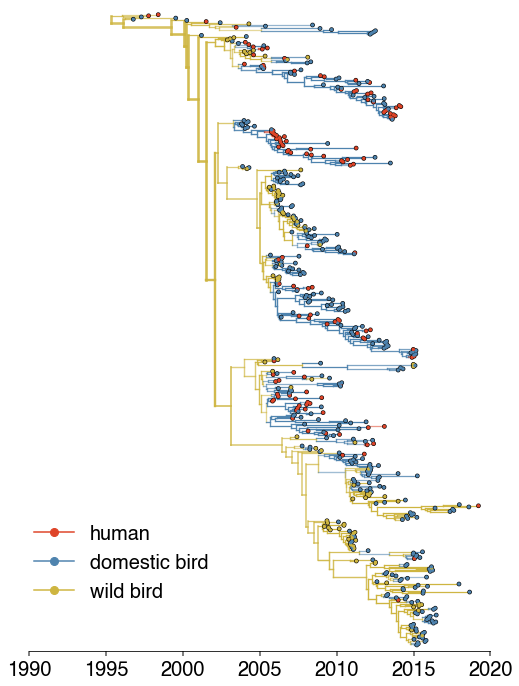

In [9]:
width = 8
length = 10
filename = "figures/mcc-tree-"+label+"-"+current_date #+".pdf"
#filename = "figures/mtt-3deme-1per-region-month-host-noGsGd-2021-01-26.pdf"
traitName = 'max'   # max for mascot, type for mtt

plot_full_mcc_tree(width, length, tree, filename, traitName)

## Enumerate subtrees and plot

In [9]:
"""enumerate host transitions on the tree"""

def retrieve_subtrees(tree, trait):
    
    traitName=trait

    tree.root.traits[traitName]='ancestor' ## give root node some trait value that's different from what the actual tree root has, so it registers as a switch

    tree_strings={host:[] for host in hosts_list}
    subtype_trees={host:[] for host in hosts_list}

    for k in sorted(tree.Objects,key=lambda x:x.height):
        kp=k.parent     # kp is the parent node of k

        ## get current node's (k) and its parent's (kp) trait states
        kloc=k.traits[traitName].lower().replace(" ","_")   # kloc = trait of k; kc = trait of k; they are the same thing
        if traitName in k.parent.traits:  # if parent has a trait block, use that trait, else assign to ancestor
            kploc=kp.traits[traitName].lower().replace(" ","_")     # kploc = trait of parental node
        else:
            kploc='ancestor'

        ## if states do not match
        if kloc!=kploc:      # if node and parental node do not have the same trait
            #N_children=len(k.leaves)
            traverse_condition=lambda w:w.traits[traitName].lower().replace(" ","_")==kloc     # traverse tree for all nodes whose traitname = kc
            #print('subtree resulting from '+kploc+' > '+kloc+' switch, traversing within '+ kloc)

            subtree=tree.subtree(k,traverse_condition=traverse_condition) ## this function returns a new baltic object that contains a trait-traversed subtree, starting from node k, for as long as the traversal stays within the starting trait value state
            
            if subtree != None:
                subtree.traverse_tree()
                subtree.sortBranches()
                if kloc in subtype_trees:
                    subtype_trees[kloc].append((kploc,subtree))
                else:
                    pass
                    #print(kloc, " not in countries list")
                    
    return(subtype_trees)

In [17]:
"""enumerate host transitions on the tree"""

def retrieve_subtrees_2_deme(tree, trait, target_host, stop_state):
    
    traitName=trait

    tree.root.traits[traitName]='ancestor' ## give root node some trait value that's different from what the actual tree root has, so it registers as a switch

    tree_strings={target_host:[]}
    subtype_trees={target_host:[]}

    for k in sorted(tree.Objects,key=lambda x:x.height):
        kp=k.parent     # kp is the parent node of k

        ## get current node's (k) and its parent's (kp) trait states
        kloc=k.traits[traitName].lower().replace(" ","_")   # kloc = trait of k; kc = trait of k; they are the same thing
        if traitName in k.parent.traits:  # if parent has a trait block, use that trait, else assign to ancestor
            kploc=kp.traits[traitName].lower().replace(" ","_")     # kploc = trait of parental node
        else:
            kploc='ancestor'

        ## if states do not match and the child is the target host
        if kloc!=kploc and kloc == target_host:      # if node and parental node do not have the same trait
            #N_children=len(k.leaves)
            traverse_condition=lambda w:w.traits[traitName].lower().replace(" ","_") in stop_state     # traverse tree for all nodes whose traitname = kc
            #print('subtree resulting from '+kploc+' > '+kloc+' switch, traversing within '+ kloc)

            subtree=tree.subtree(k,traverse_condition=traverse_condition) ## this function returns a new baltic object that contains a trait-traversed subtree, starting from node k, for as long as the traversal stays within the starting trait value state
            
            if subtree != None:
                subtree.traverse_tree()
                subtree.sortBranches()
                if kloc in subtype_trees:
                    subtype_trees[kloc].append((kploc,subtree))
                else:
                    pass
                    
    return(subtype_trees)

In [18]:
def plot_exploded_tree(subtype_trees, filename, width, height, traitName, deme, labels):
    
    color_dict = {"human":human_color, "domestic":domestic_color, "wild":wild_color, "ancestor":"grey"}#,
#                  "Southeast_Asia":"#4274CE","North_America":"#E39B39", "South_America":"#4042C7", 
#                    "China":"#E56C2F","South_Asia":"#88BB6C", "Africa":"#CEB541", "West_Asia":"#ADBD51", 
#                    "Japan_Korea":"#69B091", "Europe":"#4042C7"}
    
    mpl.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
    mpl.rc('text', usetex='false') 
    mpl.rcParams.update({'font.size': 22})
    
    fig,ax1 = plt.subplots(figsize=(width,height),facecolor='w')

    branchWidth=1.25 ## default branch width
    tipSize = 15
    origin_size=50

    mpl.rcParams['font.size']=16
    cumulative_y=0

    # this sets the vertical dashed lines on the tree
    dates = []
    date_labels = []
    for i in np.arange(1990,2030,5): 
        dates.append(i)
    #[ax1.axvline(i,ls='--',lw=1,color='grey',zorder=0, alpha=0.5) for i in dates]

    for subtree in reversed(subtype_trees[deme]): ## iterate over trait values
        origin = subtree[0]
        loc_tree = subtree[1]
        min_node_x = min(k.absoluteTime for k in loc_tree.Objects)
        
        """ Iterate through each object in the subtree, and plot a dot for each tip, and lines connecting them
        for each node. Do this for all except the horizontal line connecting the origin and the subtee"""
        for k in loc_tree.Objects:
            
            xp=k.parent.absoluteTime
            x = k.absoluteTime
            y = k.y + cumulative_y
            c = color_dict[k.traits[traitName]]
            s = tipSize
            a = k.traits[traitName+".prob"]
 
            if k.branchType == "leaf":
                #region = k.name.split("|")[4]
                #c = color_dict[region]
                ax1.scatter(x,y,s=tipSize,facecolor=c, alpha=a,edgecolor="black",zorder=100) ## plot tip circle
                ax1.scatter(x,y,s=tipSize,facecolor="black", alpha=a,edgecolor="black",zorder=99)
                
                if labels == "yes":
                    label = k.name.split("|")[0]
                    ax1.text(x+0.3,y,label, fontsize=4,zorder=13)
                else:
                    pass
                              
            elif k.branchType == "node": 
                #c = "black"
                # this plots the vertical lines connecting children and parents on tree
                ax1.plot([x,x],[k.children[-1].y + cumulative_y,k.children[0].y+ cumulative_y],lw=branchWidth,color=c,alpha=a,ls='-',zorder=9)            
            
            if xp != loc_tree.root.absoluteTime:  # don't plot line connecting subtree to origin
#                 if xp >= cutoff:
                #c = "black"
                ax1.plot([xp,x],[y,y],lw=branchWidth,color=c,ls='-',zorder=9)   # this connects horizontal tree lines
#                 else:
#                     ax1.plot([xp,cutoff],[y,y],":",lw=branchWidth,color=c,zorder=9)   # this connects horizontal tree lines
#                     ax1.plot([cutoff,x],[y,y],"-",lw=branchWidth,color=c,zorder=9)   # this connects horizontal tree lines

        """ Plot a colored circle at the origin, and plot a line connecting that circle to the subtree. Make 
        that line be dotted or solid depending on how far back the origin is and how far back the node is"""
        # first, plot the origin circle
        oriC = color_dict[origin]
        if loc_tree.root.absoluteTime==None:
            oriX=loc_tree.root.absoluteTime
            oriY=loc_tree.root.y+cumulative_y
        else:
            oriX=loc_tree.root.absoluteTime
            oriY=loc_tree.root.y+cumulative_y
        ax1.scatter(oriX,oriY,s=origin_size,facecolor=oriC,edgecolor='w',lw=1,zorder=200) ## add big circle at base of tree to indicate origin
             
        # plot dotted line connecting circle to tree 
#         if min_node_x < cutoff: # whole thing before cutoff, whole thing dotted
#             ax1.plot([min_node_x,oriX],[oriY,oriY], ":", color=c,lw=branchWidth,zorder=98)

#         elif oriX < cutoff: # partly before 2016, partial dotteds
#             ax1.plot([min_node_x,cutoff],[oriY,oriY],"-",color=c,lw=branchWidth,zorder=98)
#             ax1.plot([cutoff,oriX],[oriY,oriY],":",color=c,lw=branchWidth,zorder=98)

#         else:
        ax1.plot([min_node_x,oriX],[oriY,oriY],"-",color=c,lw=branchWidth,zorder=98)
        
        # increment cumulative y displacement
        cumulative_y+=loc_tree.ySpan+5 

    #add in a legend
    han_list = []
    for key in color_dict:
        marker = mlines.Line2D(range(1), range(1), color = color_dict[key], marker='o', markerfacecolor = color_dict[key], label = key.replace("_"," ").title(), markersize = 8)
        han_list.append(marker)
    ax1.legend(handles = han_list, markerfirst = True, edgecolor="white", bbox_to_anchor=[0, 0.12], loc=3, prop={'size': 16}, facecolor='w')

    ax1.xaxis.tick_bottom()
    ax1.yaxis.tick_left()

    [ax1.spines[loc].set_visible(False) for loc in ['top','right','left']]

    ax1.tick_params(axis='y',size=0)
    ax1.set_yticklabels([])
    ax1.set_ylim(-5,cumulative_y)
    ax1.set_xlim(dates[0],dates[-1])
    ax1.set_xticks(dates)
    #ax1.set_xticklabels(dates, fontsize=14)
    #ax1.axes.get_xaxis().set_ticks([])

    plt.savefig(filename,bbox_inches = 'tight',pad_inches = 0)
    plt.show()

In [19]:
def plot_exploded_tree_colorby_region(subtype_trees, filename, width, height, traitName, deme, labels):
    
    origin_color_dict = {"human":human_color, "domestic":domestic_color, "wild":wild_color, "ancestor":"grey"}
    color_dict = {"Southeast_Asia":"#4274CE","North_America":"#E39B39", "South_America":"#4042C7", 
                    "China":"#E56C2F","South_Asia":"#88BB6C", "Africa":"#CEB541", "West_Asia":"#ADBD51", 
                    "Japan_Korea":"#69B091", "Europe":"#4042C7"}
    
    mpl.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
    mpl.rc('text', usetex='false') 
    mpl.rcParams.update({'font.size': 22})
    
    fig,ax1 = plt.subplots(figsize=(width,height),facecolor='w')

    branchWidth=1.25 ## default branch width
    tipSize = 12
    origin_size=50

    mpl.rcParams['font.size']=16
    cumulative_y=0

    # this sets the vertical dashed lines on the tree
    dates = []
    date_labels = []
    for i in np.arange(1990,2030,5): 
        dates.append(i)
    #[ax1.axvline(i,ls='--',lw=1,color='grey',zorder=0, alpha=0.5) for i in dates]

    for subtree in reversed(subtype_trees[deme]): ## iterate over trait values
        origin = subtree[0]
        loc_tree = subtree[1]
        min_node_x = min(k.absoluteTime for k in loc_tree.Objects)
        
        """ Iterate through each object in the subtree, and plot a dot for each tip, and lines connecting them
        for each node. Do this for all except the horizontal line connecting the origin and the subtee"""
        for k in loc_tree.Objects:
            
            xp=k.parent.absoluteTime
            x = k.absoluteTime
            y = k.y + cumulative_y
            s = tipSize
            a = k.traits[traitName+".prob"]
 
            if k.branchType == "leaf":
                region = k.name.split("|")[4]
                c = color_dict[region]
                ax1.scatter(x,y,s=tipSize,facecolor=c, alpha=a,edgecolor=c,zorder=100) ## plot tip circle
                ax1.scatter(x,y,s=tipSize,facecolor="black", alpha=a,edgecolor="black",zorder=99)
                
                if labels == "yes":
                    label = k.name.split("|")[0]
                    ax1.text(x+0.3,y,label, fontsize=4,zorder=13)
                else:
                    pass
                              
            elif k.branchType == "node": 
                c = "black"
                # this plots the vertical lines connecting children and parents on tree
                ax1.plot([x,x],[k.children[-1].y + cumulative_y,k.children[0].y+ cumulative_y],lw=branchWidth,color=c,alpha=a,ls='-',zorder=9)            
            
            if xp != loc_tree.root.absoluteTime:  # don't plot line connecting subtree to origin
#                 if xp >= cutoff:
                c = "black"
                ax1.plot([xp,x],[y,y],lw=branchWidth,color=c,ls='-',zorder=9)   # this connects horizontal tree lines
#                 else:
#                     ax1.plot([xp,cutoff],[y,y],":",lw=branchWidth,color=c,zorder=9)   # this connects horizontal tree lines
#                     ax1.plot([cutoff,x],[y,y],"-",lw=branchWidth,color=c,zorder=9)   # this connects horizontal tree lines

        """ Plot a colored circle at the origin, and plot a line connecting that circle to the subtree. Make 
        that line be dotted or solid depending on how far back the origin is and how far back the node is"""
        # first, plot the origin circle
        oriC = origin_color_dict[origin]
        if loc_tree.root.absoluteTime==None:
            oriX=loc_tree.root.absoluteTime
            oriY=loc_tree.root.y+cumulative_y
        else:
            oriX=loc_tree.root.absoluteTime
            oriY=loc_tree.root.y+cumulative_y
        ax1.scatter(oriX,oriY,s=origin_size,facecolor=oriC,edgecolor='w',lw=1,zorder=200) ## add big circle at base of tree to indicate origin
             
        # plot dotted line connecting circle to tree 
#         if min_node_x < cutoff: # whole thing before cutoff, whole thing dotted
#             ax1.plot([min_node_x,oriX],[oriY,oriY], ":", color=c,lw=branchWidth,zorder=98)

#         elif oriX < cutoff: # partly before 2016, partial dotteds
#             ax1.plot([min_node_x,cutoff],[oriY,oriY],"-",color=c,lw=branchWidth,zorder=98)
#             ax1.plot([cutoff,oriX],[oriY,oriY],":",color=c,lw=branchWidth,zorder=98)

#         else:
        ax1.plot([min_node_x,oriX],[oriY,oriY],"-",color=c,lw=branchWidth,zorder=98)
        
        # increment cumulative y displacement
        cumulative_y+=loc_tree.ySpan+5 

    #add in a legend
    han_list = []
    for key in color_dict:
        marker = mlines.Line2D(range(1), range(1), color = color_dict[key], marker='o', markerfacecolor = color_dict[key], label = key.replace("_"," ").title(), markersize = 8)
        han_list.append(marker)
    ax1.legend(handles = han_list, markerfirst = True, edgecolor="white", bbox_to_anchor=[0, 0.12], loc=3, prop={'size': 16}, facecolor='w')

    ax1.xaxis.tick_bottom()
    ax1.yaxis.tick_left()

    [ax1.spines[loc].set_visible(False) for loc in ['top','right','left']]

    ax1.tick_params(axis='y',size=0)
    ax1.set_yticklabels([])
    ax1.set_ylim(-5,cumulative_y)
    ax1.set_xlim(dates[0],dates[-1])
    ax1.set_xticks(dates)
    #ax1.set_xticklabels(dates, fontsize=14)
    #ax1.axes.get_xaxis().set_ticks([])

    plt.savefig(filename,bbox_inches = 'tight',pad_inches = 0)
    plt.show()

In [20]:
hosts_list = ['human','wild','domestic']
trait = 'max'

subtype_trees = retrieve_subtrees(tree, trait)

In [16]:
print(len(subtype_trees['domestic']))
print(len(subtype_trees['human']))

132
112


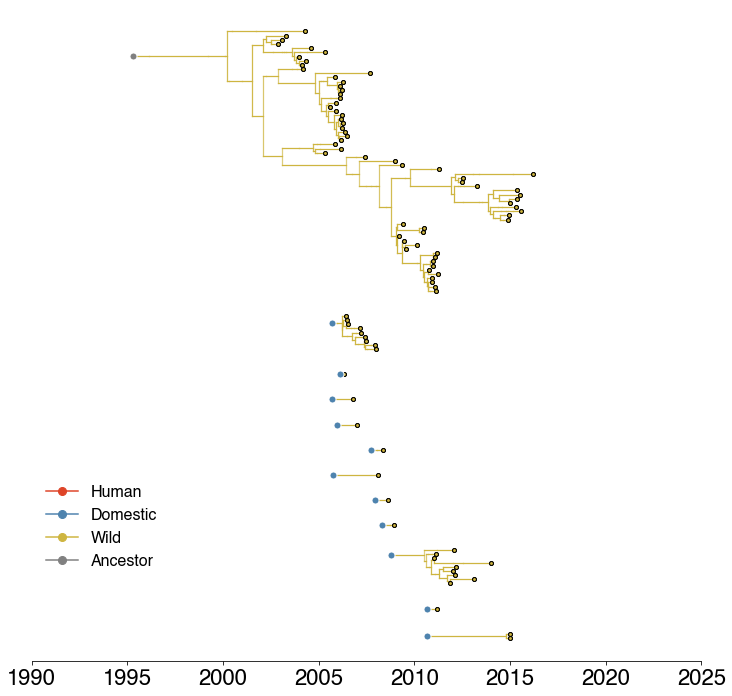

In [25]:
width = 12
height = 12
traitName = 'max'
deme = 'wild'
labels = "no"
filename = "figures/exploded-tree-"+label+"-"+deme+"-"+current_date+".pdf"
#filename = "figures/exploded-tree-mtt-3deme-1per-region-month-host-noGsGd-2021-01-26.pdf"

plot_exploded_tree(subtype_trees, filename, width, height, traitName, deme, labels)

In [22]:
# this will generate an exploded tree with domestic introductions that also includes human tips 
trait = 'max'
target_host = "domestic"
stop_state = ["domestic","human"]

subtype_trees2 = retrieve_subtrees_2_deme(tree, trait, target_host, stop_state)

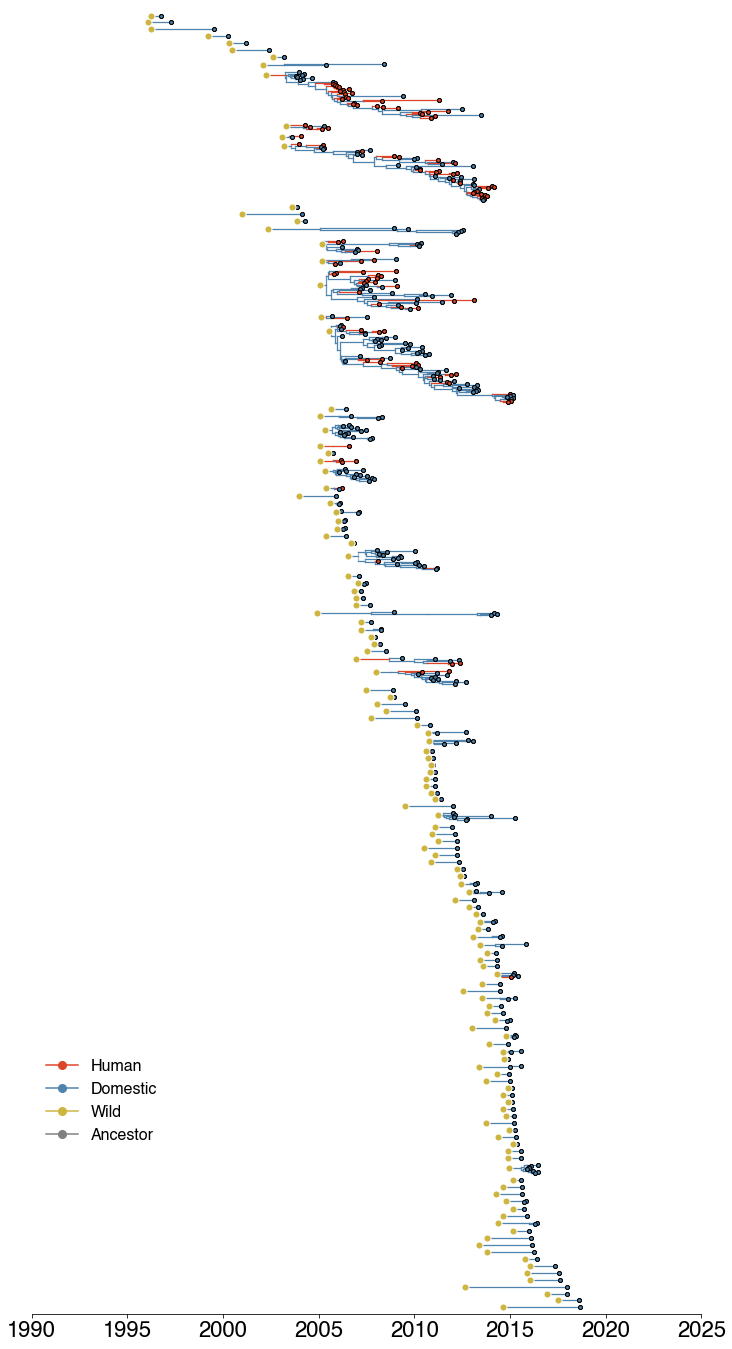

In [25]:
# there is something off about this code. I think it's the plotting, but it could also be the subtrees themselves
width = 12
height = 24
traitName = 'max'
deme = 'domestic'
labels = "no"
filename = "figures/exploded-tree-"+label+"-"+deme+"-"+current_date+".pdf"
#filename = "figures/exploded-tree-mtt-3deme-1per-region-month-host-noGsGd-2021-01-26.pdf"

plot_exploded_tree(subtype_trees2, filename, width, height, traitName, deme, labels)

## Evaluate cluster sizes and time of circulation

In [13]:
def infer_large_clusters(subtype_trees, cutoff_value):
    large_clusters = {}
    
    for deme in subtype_trees: 
        large_clusters[deme] = []
        
        for subtree in subtype_trees[deme]:
            trans_from = subtree[0]
            tree = subtree[1]
            number_tips = 0
            for k in tree.Objects: 
                if k.branchType == "leaf":
                    number_tips += 1
            #total_tips = tree.root.leaves  # leaves is the total # descendant tips, children is just the immediate descendants
            if number_tips > cutoff_value:
                to_add = (trans_from,tree)
                large_clusters[deme].append(to_add)

    return(large_clusters)

In [14]:
# characterize introduction sizes
def output_cluster_sizes(subtype_trees):
    cluster_sizes = {}
    
    for deme in subtype_trees: 
        cluster_sizes[deme] = {}
        
        for subtree in subtype_trees[deme]:
            trans_from = subtree[0]
            tree = subtree[1]
            number_tips = 0
            for k in tree.Objects: 
                if k.branchType == "leaf":
                    number_tips += 1
            #total_tips = tree.root.leaves  # leaves is the total # descendant tips, children is just the immediate descendants
            if number_tips in cluster_sizes[deme]:
                cluster_sizes[deme][number_tips] += 1
            else:
                cluster_sizes[deme][number_tips] = 1

    return(cluster_sizes)

In [15]:
def output_cluster_times(subtype_trees):
    cluster_times = {}
    
    for deme in subtype_trees: 
        cluster_times[deme] = []
        
        for subtree in subtype_trees[deme]:
            dates = []
            trans_from = subtree[0]
            tree = subtree[1]
            
            for k in tree.Objects: 
                if k.branchType == "leaf":
                    # pull the date
                    date = float(k.name.split("|")[1])
                elif k.branchType == "node":
                    date = k.absoluteTime
                dates.append(date)
                
            minimum_date = min(dates)
            maximum_date = max(dates)
            date_range = maximum_date - minimum_date
            
            cluster_times[deme].append(date_range)

    return(cluster_times)

In [16]:
cutoff_value = 1
large_clusters = infer_large_clusters(subtype_trees, cutoff_value)
large_clusters

{'human': [('domestic', <baltic.tree at 0x7fc8cd5764a8>),
  ('domestic', <baltic.tree at 0x7fc8cd51d438>),
  ('domestic', <baltic.tree at 0x7fc8cd791518>),
  ('domestic', <baltic.tree at 0x7fc8cedc7438>),
  ('domestic', <baltic.tree at 0x7fc8cd52bd68>),
  ('domestic', <baltic.tree at 0x7fc8cd78d4a8>),
  ('domestic', <baltic.tree at 0x7fc8d00abf98>),
  ('domestic', <baltic.tree at 0x7fc8ceca3860>),
  ('domestic', <baltic.tree at 0x7fc8cea64668>),
  ('domestic', <baltic.tree at 0x7fc8cd67da20>)],
 'wild': [('ancestor', <baltic.tree at 0x7fc8cd35f400>),
  ('domestic', <baltic.tree at 0x7fc8cec9ff28>),
  ('domestic', <baltic.tree at 0x7fc8d007cba8>),
  ('domestic', <baltic.tree at 0x7fc8d030c9e8>)],
 'domestic': [('wild', <baltic.tree at 0x7fc8cd5fc780>),
  ('wild', <baltic.tree at 0x7fc8cd3a0b00>),
  ('wild', <baltic.tree at 0x7fc8cd737748>),
  ('wild', <baltic.tree at 0x7fc8ceca30f0>),
  ('wild', <baltic.tree at 0x7fc8cefb5438>),
  ('wild', <baltic.tree at 0x7fc8cd1e77b8>),
  ('wild', <b

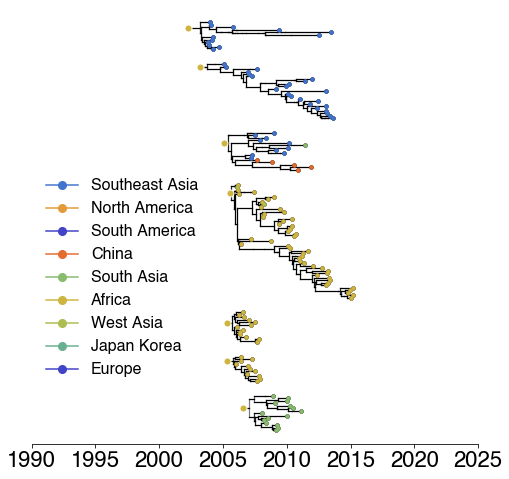

In [20]:
width = 8
height = 8
traitName = 'max'
deme = 'domestic'
labels = "no"
filename = "figures/exploded-tree-large-clusters-region-"+label+"-"+deme+"-"+current_date+".pdf"
#filename = "figures/exploded-tree-large-clusters-mtt-3deme-4rates-2020-12-08.pdf"

plot_exploded_tree_colorby_region(large_clusters, filename, width, height, traitName, deme, labels)

In [21]:
cluster_times_dict = output_cluster_times(subtype_trees)
#cluster_times_dict

In [17]:
cluster_sizes_dict = output_cluster_sizes(subtype_trees)
cluster_sizes_dict

{'human': {1: 102, 2: 9, 5: 1},
 'wild': {63: 1, 9: 2, 1: 8, 2: 1},
 'domestic': {1: 93,
  2: 19,
  12: 1,
  23: 1,
  6: 1,
  7: 2,
  16: 1,
  47: 1,
  3: 5,
  13: 1,
  11: 1,
  15: 1,
  4: 3,
  10: 1,
  8: 1}}

In [23]:
cluster_times_df = pd.DataFrame()

for deme in cluster_times_dict:
    local_df = pd.DataFrame.from_dict({"deme":deme, "circulation_time":cluster_times_dict[deme]})
    cluster_times_df = cluster_times_df.append(local_df)
    
cluster_times_df.head()

,deme,circulation_time
0,human,0.0
1,human,0.0
2,human,0.0
3,human,0.0
4,human,0.0


/Users/lmoncla/anaconda/envs/LHM-basics/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
/Users/lmoncla/anaconda/envs/LHM-basics/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Loading required package: ggplot2

  warnings.warn(x, RRuntimeWarning)


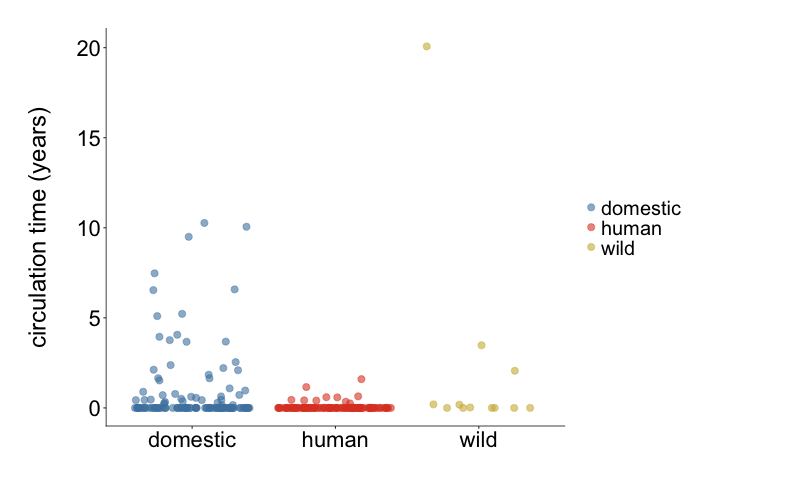

In [24]:
%%R -w 800 -h 500 -u px -i current_date,label,cluster_times_df,human_color,wild_color,domestic_color # this sets the size of the plot...otherwise, it will go off the page

require(ggplot2)
library(ggplot2)
library(RColorBrewer)

output_filename = paste("cluster-times-",label,"-",current_date,".pdf", sep="")

p <- ggplot(data=cluster_times_df, aes(x=deme, y=circulation_time, color=deme)) + 
    geom_jitter(alpha=0.6, size=3)+
    labs(x="",y="circulation time (years)\n")+
    scale_color_manual(values=c(human=human_color,wild=wild_color,domestic=domestic_color))+
#     scale_y_continuous(breaks=seq(0,0.8,0.2), limits=c(0,0.8))+
#     scale_x_continuous(breaks=seq(0,1,0.2), limits=c(-0.05,1.0))+
    theme(panel.grid.major=element_line(colour=NA,size=NA))+    
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+    
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(axis.title=element_text(size=24, vjust=5))+
    theme(axis.text.y=element_text(size=22, colour="black"))+
    theme(axis.text.x=element_text(size=22, colour="black", hjust=0.5))+
    theme(legend.text=element_text(size=20))+
    theme(legend.title=element_blank())+
    theme(panel.margin=unit(1, "lines"))+
    theme(plot.margin=unit(c(1,4,1,1),"cm"))+
    theme(legend.key.size=unit(0.7, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))
    ##theme(legend.position = c(legend_x, legend_y))

ggsave(output_filename, width = 12, height = 5, device = "pdf", path = "figures", dpi = 300)
p